In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from models import BinaryClassifier
import torch
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)
        plt.legend()

In [3]:
from sklearn.datasets import make_moons
x, label = make_moons(10000, noise = .04)
target_samples_1 = torch.tensor(x[label == 1])[:1000]
target_samples_0 = torch.tensor(x[label == 0])[:1000]

In [4]:
binary_classif = BinaryClassifier(target_samples_1.float(), target_samples_0.float(), [64,64,64])
binary_classif.train(500)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.75it/s, loss = 0.34276]


c:\users\ea264728\pycharmprojects\neural-density-ratio\venv\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


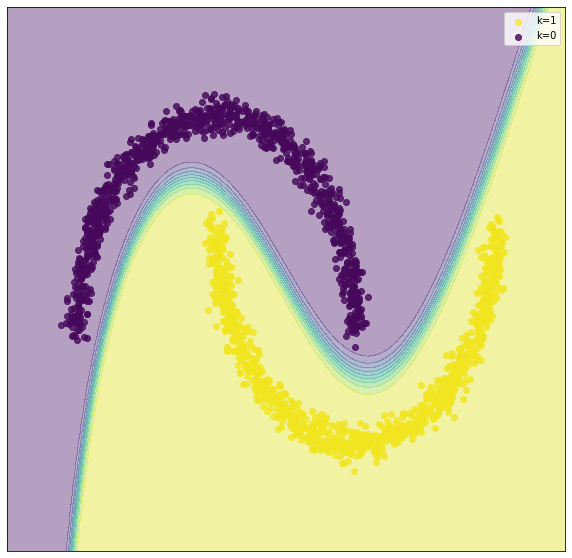

In [5]:
plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.scatter(target_samples_1[:,0].numpy(),target_samples_1[:,1].numpy(), color = matplotlib.cm.get_cmap('viridis')(0.999), alpha = 0.8, label = 'k=1')
plt.scatter(target_samples_0[:,0].numpy(),target_samples_0[:,1].numpy(), color = matplotlib.cm.get_cmap('viridis')(0.001), alpha = 0.8, label ='k=0')
plot_2d_function(lambda x: torch.sigmoid(binary_classif.logit_r(x)), x_min = -1.5, x_max = 2.5, y_min = -1, y_max = 1.5, levels = 10, alpha = 0.4, new_figure =False)

In [44]:
class TwoCircles():
    def __init__(self):
        super().__init__()

    def sample(self,num_samples, means = torch.tensor([1.,2.]),weights = torch.tensor([.5,.5]), noise = 0.125):
        angle = torch.rand(num_samples)*2*math.pi
        cat = torch.distributions.Categorical(weights).sample(num_samples)
        x,y = means[cat]*torch.cos(angle) + torch.randn_like(angle)*noise,means[cat]*torch.sin(angle) + torch.randn_like(angle)*noise
        return torch.cat([x.unsqueeze(-1),y.unsqueeze(-1)], dim =-1)

    def log_prob(self,samples, means = torch.tensor([1.,2.]),weights = torch.tensor([.5,.5]), noise = 0.125):
        r = torch.norm(samples, dim=-1).unsqueeze(-1)
        cat = torch.distributions.Categorical(weights)
        mvn = torch.distributions.MultivariateNormal(means.unsqueeze(-1), torch.eye(1).unsqueeze(0).repeat(2,1,1)*noise)
        mixt = torch.distributions.MixtureSameFamily(cat, mvn)
        return mixt.log_prob(r)

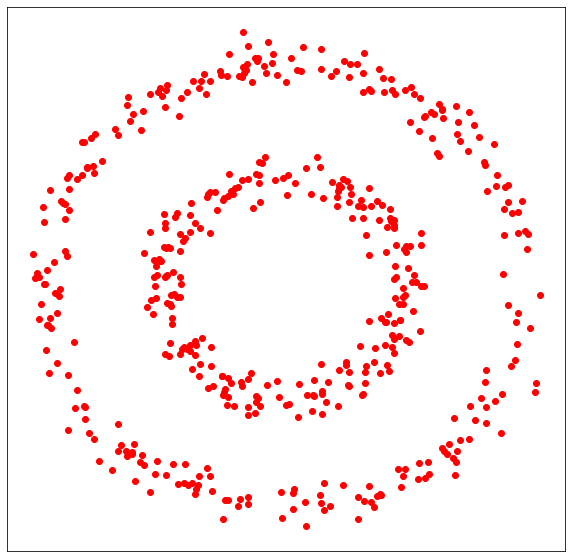

In [89]:
target_samples = TwoCircles().sample([500], noise = 0.1)
plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.scatter(target_samples[:,0], target_samples[:,1], color = 'red')

In [90]:
cov = torch.cov(target_samples.T)
proposal = torch.distributions.MultivariateNormal(torch.mean(target_samples, dim = 0), 1/2*cov + 1/2*cov.T)
proposed_samples = proposal.sample([10000])
binary_classif = BinaryClassifier(target_samples, proposed_samples, [256,256,256])
binary_classif.train(1000)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:38<00:00,  1.93it/s, loss = 68.254356]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


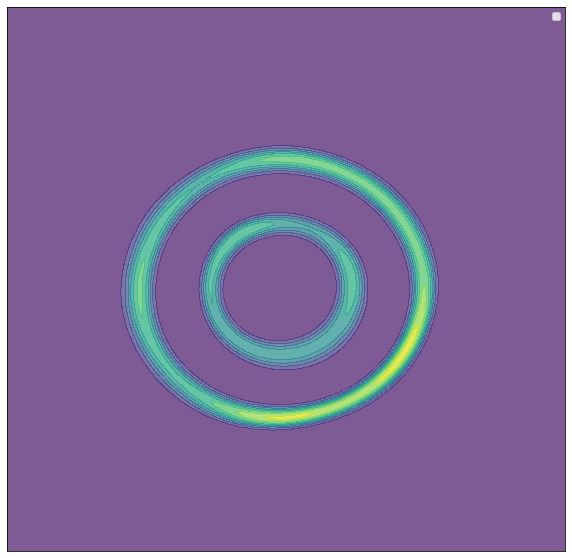

In [84]:
plt.figure(figsize = (10,10))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plot_2d_function(lambda x: torch.sigmoid(binary_classif.logit_r(x)), x_min = torch.min(NF_samples[:,0]), x_max =torch.max(NF_samples[:,0]), y_min = torch.min(NF_samples[:,1]), y_max =torch.max(NF_samples[:,1]) , levels = 10, new_figure = False)

In [86]:
def run_approx_IMH(number_steps, proposal, number_chains):
    state = proposal.sample([number_chains])
    for _ in range(number_steps):
        proposed_samples = proposal.sample([number_chains])
        acceptance_log_prob = binary_classif.log_density_ratio(proposed_samples) - binary_classif.log_density_ratio(state)
        mask = ((torch.rand(state.shape[0]) < torch.exp(acceptance_log_prob)) * 1.).unsqueeze(-1)
        state = (mask)*proposed_samples + (1-mask)*state
    return state

In [87]:
samples = run_approx_IMH(200,proposal, 5000)

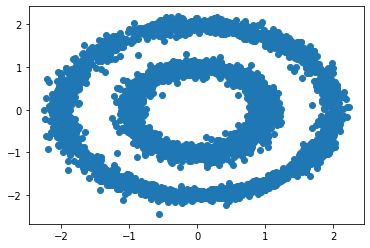

In [88]:
plt.scatter(samples[:,0], samples[:,1])